In [60]:
!pip3 install pandas umap-learn matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [61]:
import pandas as pd
#import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# <font color='#3c3c3c'>Introduction</font>

text

# <font color='#3c3c3c'>EDA</font>

In [62]:
df = pd.read_csv("SpotifyFeatures.csv")
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


The first step we took was to find out some basic information about our dataset, such as the shape of the dataset, the names of the columns available, any missing values, and some general summary statistics. We also check for any duplicated values, to maintain a clean database. This way, we gain a general overview of the data we are working with.

Upon checking the shape and column names, as well as some summary stats, we observe:
- The dataset has 232725 rows and 18 columns.
- Most columns are numeric, which is preferred for ML models.
- There is only 1 missing value, track_name which has 232724 rows instead of 232725.
- key, mode, and time_signature are stored as 'object' type rather than numeric, so they will need to be converted into integers.
- Text columns, such as artist_name, track_name, and track_id, will most probably not be useful for predicting mood, and may be dropped in the future.
- Overall, the dataset seems clean and ready for preprocessing, with only some minor adjustments needed.

In [63]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (232725, 18)

Column Names:
 Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


In [64]:
# summary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

The next step we took was to generate summary statistics for all of the numerical columns, in order to have a better idea of the feature scales, skewness, and any potential outliers that we should handle during preprocessing. Some key observations include:
1. Popularity:
    - The mean is 41.13, and the median is 43, indicating a roughly symmetric distribution.
    - The 25th percentile is 29, so most songs in this dataset are not very popular.
    - Std = 18.19, so a decent spread of popularity levels.
2. Acousticness:
    - Mean (0.369) > median (0.232), so it is a right skewed distribution
    - The 75th percentile is 0.722, meaning 75% of songs have acousticness below 0.722, This means most songs are not very acoustic.
    - The max val is close to 1, so some songs are fully acoustic. This reflects modern music trends, where most tracks are digitally produced.
    - Std = 0.355, showing high spread, so it is important for distinguishing acoustic/chill moods.
3. Danceability:
    - The mean (0.55) and median (0.57) are almost equal, suggesting a fairly symmetric distribution, so most songs are just moderately danceable.
    - This feature may help in differentiating between calm/chill (low danceability) or party/energetic (high danceability).
    - Std of 0.186, indicating moderate spread.
4. Duration:
    - The mean is 235000ms, so the average song lasts about 3.9 minutes.
    - The maximum song length is 5.5 million ms, which is around 92 minutes. This is an outlier we might have to deal with in the future.
    - The standard deviation is 118,936 ms, a very high spread mainly due to extreme outliers.
5. Energy:
    - Mean (0.57) < median (0.61), suggesting a slight left skew and a moderately energetic dataset.
    - Std = 0.263, implying a good spread and high predictive potential for energetic vs calm moods.
6. Instrumentalness:
    - Mean (0.15) > median (0.00004), so it is extremely right skewed.
    - 75% of songs < 0.036, so most songs contain vocals.
    - The standard deviation is 0.303, showing a high spread.
7. Liveness:
    - Max value of 1, meaning some live performances exist in the dataset.
    - Std of 0.198 indicates moderate spread, but weaker predictive power compared to other features.
8. Loudness:
    - A mean of -9.57dB, which is the spotify standard.
    - Min of -52dB, which could be silence or bad audio, and max of 3.74dB (unusually loud).
    - Std = 6 dB, so a very wide range of loudness levels, which could be important for capturing aggressive vs softer moods.
9. Speechiness:
    - Measures how much a track sounds like spoken words rather than musical singing.
    - Max of 0.97, may represent podcasts
    - Mean (0.12) > median (0.05), indicating high right skew (most songs are musical)
    - Std = 0.186, showing moderate spread.
10. Tempo:
    - Mean of 118 BPM matches most pop/rock music.
    - Wide range, (30-243) so most tracks are super slow/fast.
    - Std of 30.90 BPM, indicating high spread and good potential for predicting energetic vs calm moods.
11. Valence:
    - Positivity vs negativity. Mean (0.45) and median (0.44) are almost equal, indicating a centered distribution.
    - Std = 0.260, showing good spread across different emotional tones.
    - This may be very helpful for mood prediction, low valence may suggest sadness, and high happiness.

This statistical exploration allowed us to understand outliers, distributions, and spread of a feature. To better visualize the distributions of our features, we will actually plot the distributions in next steps.

In [65]:
# summary statistics
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


A formal check for missing values using .isnull and .sum allows us to confirm what we observed earlier, only one missing value which is in track_name.

In [66]:
# check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


Then, we check for any duplicate rows in the dataset. Thankfully, there were no duplicate rows and so no further action was necessary.

In [67]:
# duplicate tracks
df.duplicated().sum()

np.int64(0)

In [68]:
audio_features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'liveness', 'speechiness', 'instrumentalness', 'loudness']


Valence Distribution

The plot below shows the distribution of the valence feature. This feature measures how happy and cheerful a song sounds. These values range from 0.0 (very sad and negative) to 1.0 (very happy and positive). We can observe that there is a spike near 0.0, which means that there is a high number of sad songs (low valence songs). Aside from that, the distribution is fairly uniform between 0.1 until 0.8. This indicates that the majority of the songs span across a broad emotional range. We can also note that there is a noticeable drop at 1.0, meaning that there are few songs with a truly happy or upbeat emotional tone. In addition, the skewness of 0.14, indicates that distribution is nearly symmetric, with only a very slight right skew that indicates there are more high valence songs than low valence near the tail. The kurtosis of -1.01 also highlights that the valence values are well distributed, as it means that our distribution is flatter than normal with lighter tails (so values are evenly spread out).

This distribution also highlights a possible mood labeling strategy that would quantify the emotional positivity or negativity of a song depending on our scale from 0 to 1. Since we have yet to explore the rest of the features though, this remains just an initial proposal. 


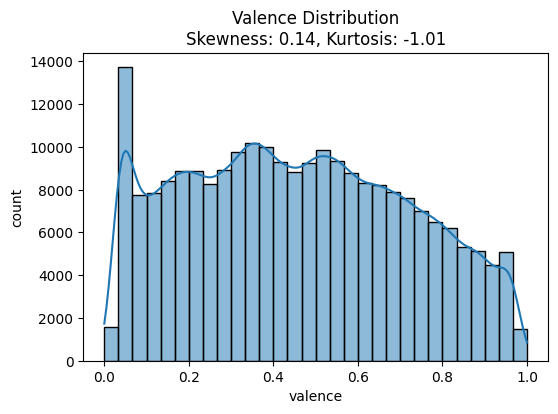

In [69]:
from scipy.stats import skew, kurtosis

# Calculate stats
valence_skew = skew(df['valence'], nan_policy='omit')
valence_kurtosis = kurtosis(df['valence'], nan_policy='omit')

# Plot
plt.figure(figsize=(6, 4))
sns.histplot(df['valence'], kde=True, bins=30)
plt.title(f'Valence Distribution\nSkewness: {valence_skew:.2f}, Kurtosis: {valence_kurtosis:.2f}')
plt.xlabel('valence')
plt.ylabel('count')
plt.show()


The energy distribution is slightly left-skewed, with the highest frequency of values around 10,000 and the lowest around 4,500. The skewness of -0.40 confirms this leftward skew, meaning there are more high-energy values than low-energy values. We also printed the kurtosis value to better understand the shape of the distribution, -0.81. Since it is less than 0 then this means that it has a flatter peak and less outliers (extreme valies) than a normal distribution, making the overall distribution more spread out.

In the context of our model's objective, understanding the distribution of the song's energy is probably a strong predictor for mood since high-energy songs tend to be "happy" while low-energy songs tend to be sad. Results show that most songs in the dataset are moderately to highly energetic, which suggests the model will be trained on a dataset biased toward more upbeat or intense moods. So, we need to keep an eye out to handle this during the training. Despite the imbalance, the feature appears to be useful and unlikely to mislead the model due to noise or outliers.

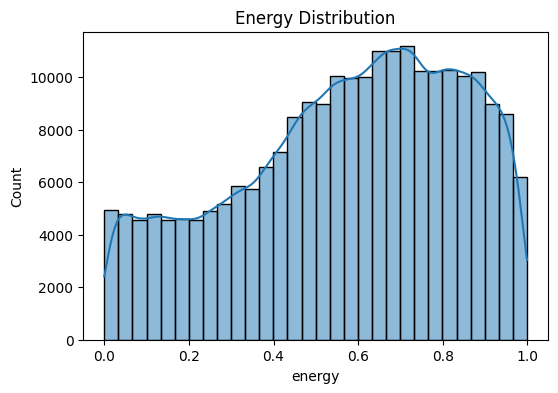

In [70]:
plt.figure(figsize=(6, 4))
sns.histplot(df['energy'], kde=True, bins=30)
plt.title('Energy Distribution')
plt.show()


In [71]:
print("Skewness:", df['energy'].skew())
print("Kurtosis:", df['energy'].kurt())

Skewness: -0.40022327921151274
Kurtosis: -0.8135949529345483


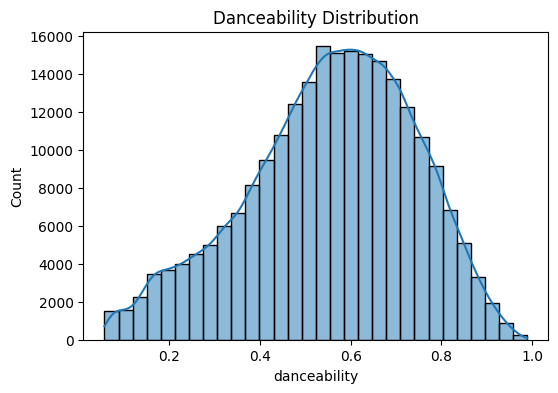

In [72]:
plt.figure(figsize=(6, 4))
sns.histplot(df['danceability'], kde=True, bins=30)
plt.title('Danceability Distribution')
plt.show()


We can see that most songs fall under the extremes with very few in the medium range(0.4-0.6) There is a huge spike on 0.0 meaning that they are likely electronic, synthetic, or heavy produced tracks. There is a smaller spike on 1.0 which means that these are acoustic, live recording etc. 

In what we saw in the stats table above we can see that this makes sense as the mean is 0.368 which means that it goes towards a lower acousticness

We can see that the skewness of the graph being 0.53, which is a positive skew, and it means that most songs have low acoustic content, with a long tail of high acoustic tracks.
The kurtosis being of -1.29 means that values are more evenly spread across the range with fewer extreme outliers

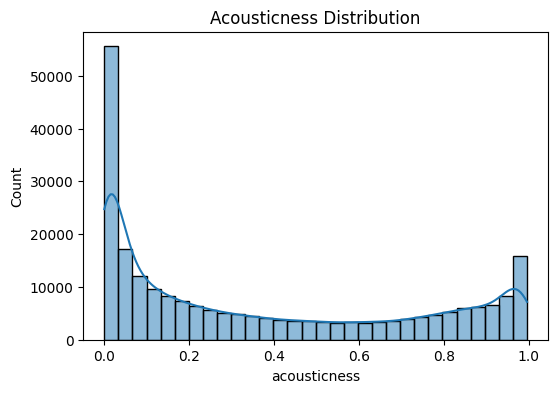

Skewness of acousticness: 0.53
Kurtosis of acousticness: -1.29


In [73]:
from scipy.stats import skew, kurtosis
plt.figure(figsize=(6, 4))
sns.histplot(df['acousticness'], kde=True, bins=30)
plt.title('Acousticness Distribution')
plt.show()

acousticness_data = df['acousticness']

skewness = skew(acousticness_data)
kurt = kurtosis(acousticness_data)

print(f"Skewness of acousticness: {skewness:.2f}")
print(f"Kurtosis of acousticness: {kurt:.2f}")


The distribution of the tempo variable shows that most songs fall between the 90 and 130 bpm range. There's a clear peak around 100-110 bpm, which suggests that there is a presence of mid-tempo tracks maybe more chill and mainstream music. There is also a smaller bump around 120-130 bpm, meaning more energetic genres.

We can also see that tracks under 80 bpm are more uncommon, probably indicating sadder or mellow songs. On the other hand, we see a long tail of faster songs that go past 150 bpm. These might behave differently in mood prediction and could potentially act like outliers.

The skewness value of 0.403 indicates a mild right-skew. This confirms what we've discussed: basically that most songs are in the mid-tempo range, but there is a small group of faster tracks that extend the tail to the right. The kurtosis is -0.467, meaning the distribution is slightly flatter than a normal distribution. Tempo values are more spread out and less sharply peaked, but still fairly balanced and centered around a 90-130 bpm range. 

This plot helps us visualize and confirm what we see in the descriptive stats table above. With tempo values ranging from 30.38 bpm to 242.90 bpm, and having a mean of ~117.7 bpm and a median of ~115.8 BPM, we can assume tempo is slightly right-sweked. The spread, represented by std = 30.9, along with the kurtosis value suggest the dataset includes a good variety or tempo styles without extreme concetration in a specific range.

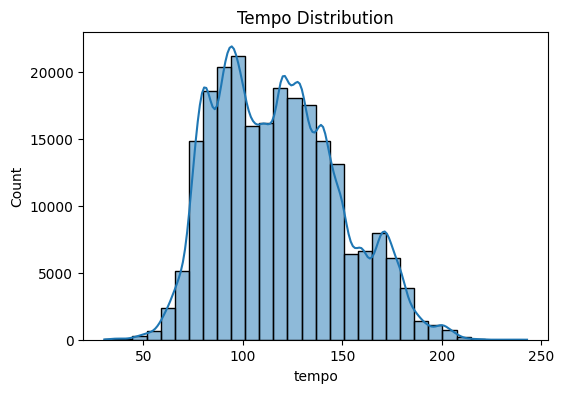

In [74]:
plt.figure(figsize=(6, 4))
sns.histplot(df['tempo'], kde=True, bins=30)
plt.title('Tempo Distribution')
plt.show()


Liveness Distribution

Liveness is measuring the prescence of a live audience or live performance characteristics in a track, going from 0.0 to 1.0.  
The graph shows a strong positive skew since most values have a liveness close to 0, meaning a majority of tracks are studio recorded, not live. This is reinforced with the skewness of 2.07 (which implies a strong positive skew). The kurtosis of 3.89 indicates a high peak around 0.1 and a heavier tail, meaning that few songs deviate strongly from the norm. Since this distribution is highly skewed, using it in the model without any type of scaling or transformation could hurt performance. This is something we will take into account in future steps. From this graph, we can also conclude that liveness is likely not particularly useful when detecting mood since most values are concentrated under 0.3. 

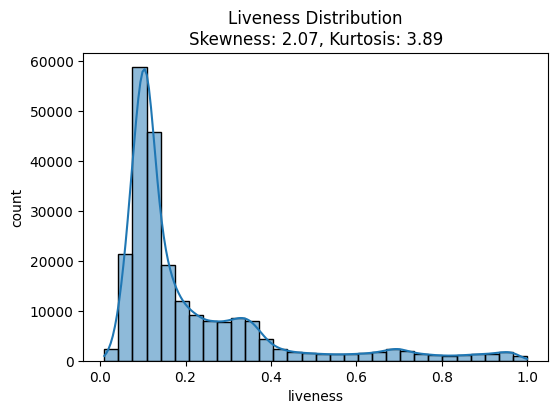

In [75]:
# Calculate skewness and kurtosis for liveness
liveness_skew = skew(df['liveness'], nan_policy='omit')
liveness_kurt = kurtosis(df['liveness'], nan_policy='omit')

# Plot
plt.figure(figsize=(6, 4))
sns.histplot(df['liveness'], kde=True, bins=30)
plt.title(f'Liveness Distribution\nSkewness: {liveness_skew:.2f}, Kurtosis: {liveness_kurt:.2f}')
plt.xlabel('liveness')
plt.ylabel('count')
plt.show()


We can see that higher values indicate more speech-like content (such as podcasts, rap, or voiceovers), and lower values represent typical musical tracks with singing. 

We can see that the graph is highly right-skewed (3.31), with most values being concentrated around 0.0 which means that most of the songs have minimal-speech content. This makes sense since most songs are sung rather than spoken dialogues, which is how spotify actually measures speechiness.

 
The kurtosis of 10.98 means that there is a highly peaked distribution, it means that while most songs cluster around low speechiness, there are notable outliers with significant higher values which likely corresponds to genres with high spoken content such as rap, etc.

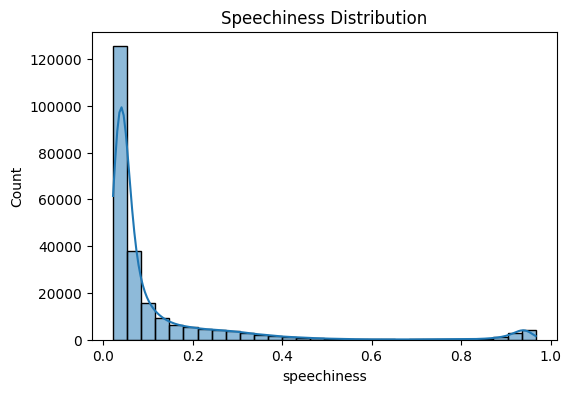

Skewness: 3.31
Kurtosis: 10.98


In [76]:
from scipy.stats import skew, kurtosis
plt.figure(figsize=(6, 4))
sns.histplot(df['speechiness'], kde=True, bins=30)
plt.title('Speechiness Distribution')
plt.show()


speechiness_data = df['speechiness']
print(f"Skewness: {skew(speechiness_data):.2f}")
print(f"Kurtosis: {kurtosis(speechiness_data):.2f}")

The distribution of the instrumentalness feature is heavily right-skewed. It has a significant peak near 0, which indicates that most tracks in the dataset have vocals. There is also a very small cluster of tracks with instrumentalness close to 1.0. These represent instrumental-only songs. These take up a small portion of the dataset, but they're still important because they may behave differently in mood modeling.

The instrumentalness distribution shows a strong right-skew, confirmed by a skewness of 1.820, meaning most tracks have very low instrumentalness.

The kurtosis is 1.588, indicating a distribution that is more peaked than normal, with heavy tails. This means while most songs cluster near zero, there’s a distinct minority of fully instrumental tracks that stand out at the upper end of the scale.

Lastly, the instrumentalness feature has a mean of ~0.15 and a median of 0.0, indicating that over half the tracks have no instrumental quality, in other words they contain vocals. The minimum, 25th, and 50th percentiles are all exactly 0.0, which show that the majority of tracks fall at the very bottom of the scale. However, the maximum value reaches 0.999, showing that some tracks are fully instrumental.

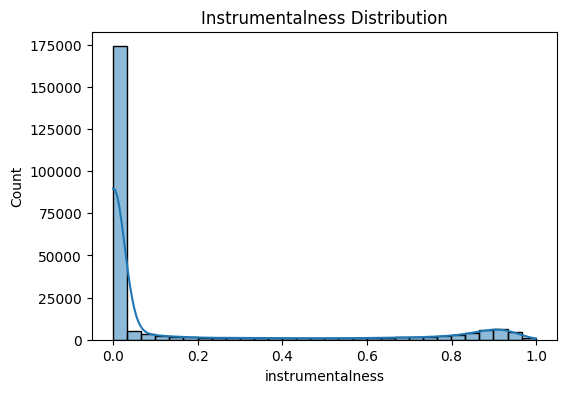

Instrumentalness Skewness: 1.820
Instrumentalness Kurtosis: 1.588


In [77]:
plt.figure(figsize=(6, 4))
sns.histplot(df['instrumentalness'], kde=True, bins=30)
plt.title('Instrumentalness Distribution')
plt.show()

inst_data = df['instrumentalness'].dropna()

inst_skew = skew(inst_data)
inst_kurt = kurtosis(inst_data)  # Fisher's definition: normal = 0

print(f"Instrumentalness Skewness: {inst_skew:.3f}")
print(f"Instrumentalness Kurtosis: {inst_kurt:.3f}")

The loudness feature in the dataset has values ranging from -52.46 dB to 3.74 dB, with a mean of -9.57 dB and a median of -7.76 dB. This means most tracks are fairly loud, represented by those close to 0 dB, while only a small minority are significantly quieter.

The distribution is left-skewed, the skewness being -1.662, which is clearly visible in the histogram. There’s a long tail of very quiet tracks pulling the distribution to the left.

The kurtosis is 3.207, indicating that the distribution is sharply peaked with heavy tails. This suggests that most tracks are clustered tightly around typical loudness values ( -10 to -5 dB), but there are outliers at both extremes (super loud and super soft).

To conclude, this means loudness is a solid feature for modeling the intensity of a track. Louder songs may correlate with high-energy or party moods, while quieter tracks could lean more toward chill, acoustic, or emotional vibes. This will all help in mood predicting.

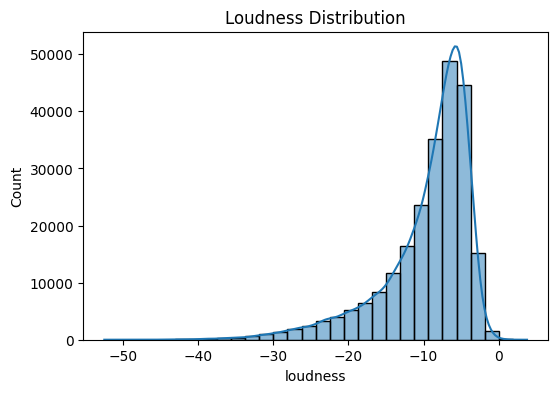

Loudness Skewness: -1.662
Loudness Kurtosis: 3.207


In [78]:
plt.figure(figsize=(6, 4))
sns.histplot(df['loudness'], kde=True, bins=30)
plt.title('Loudness Distribution')
plt.show()

loud_data = df['loudness'].dropna()

loud_skew = skew(loud_data)
loud_kurt = kurtosis(loud_data)  # Fisher's definition: normal = 0

print(f"Loudness Skewness: {loud_skew:.3f}")
print(f"Loudness Kurtosis: {loud_kurt:.3f}")

Now, to further analyze the relationship between the features, we have decided to print a correlation map since it's the easiest to visualize. If we consider those positive or negatives values greater than 0.6, then the graph shows three strong correlations. 
- **loudness vs acousticness (-0.69)**: This means that as the loudness of a track increases (strong negative correlation), the acousticness tends to decrease, and vice versa. In the context our model, this helps us better understand how "intense" or "natural" a song is. We could potentially remove one to decrease the number of features, but we beleive both are revelant since they describe different things.

- **energy vs acousticness (-0.73)**: This means that as the energy increases the acousticness decreases (strong negative correlation). Which makes sense since high-energy music often involves more synthesized or amplified sounds, whereas acoustic music tends to be calmer, with less energy.  This relationship reinforces the idea that energy could be an important feature for predicting moods like excited, angry, or happy, while acousticness might be more relevant for moods like calm or sad. Additionally, this is similar to the previous relationship, where we are not sure we should remove one or the other becuase both feature describe different things and can help predict different moods that are similar to just "happy" or "sad".

- **energy vs loudness (0.82)**: This means that as energy increases, so does the loudness (strong postive correlation). This is expected, as more intense and energetic music often has higher volumes and more dynamic sound. Since these features are more related to each other in terms of what they describe, typically upbeat, excited, or happy moods, maybe it we could drop one. 

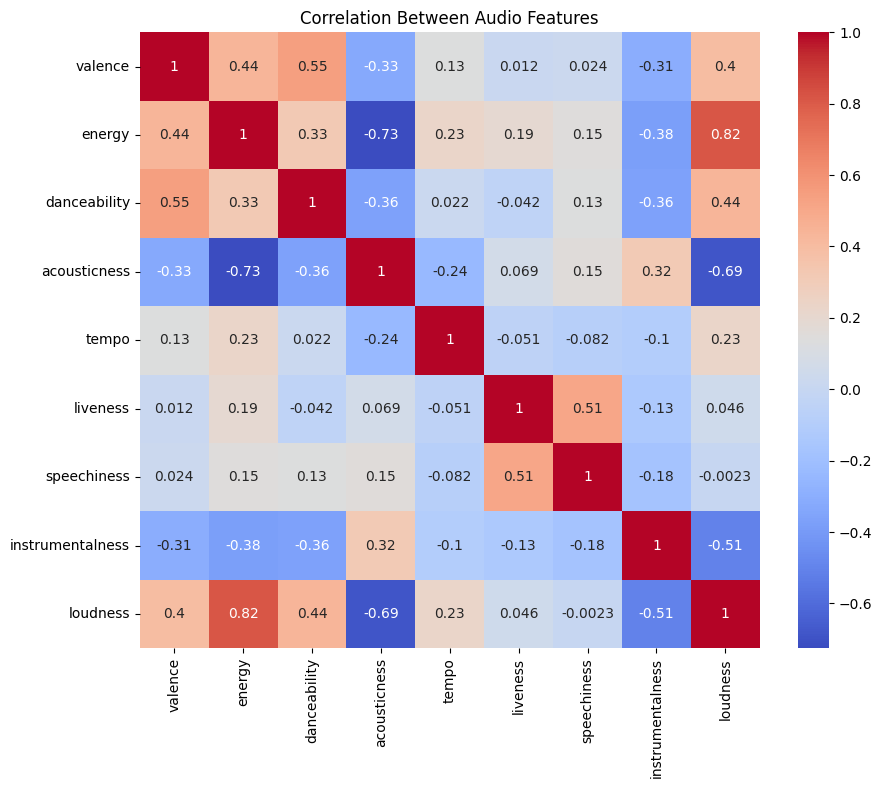

In [79]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[audio_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Audio Features')
plt.show()


The first bar plot shows the top genres in the dataset, with each bar representing the number of tracks per genre. We can see that within these genres, there are roughly an equal amount of songs (nearly 1000)


The valence feature captures the musical positivity or emotional brightness of a song, where values closer to 1.0 indicate a happy, cheerful, or euphoric tone, and values near 0.0 suggest sadness, melancholy, or tension.

Analyzing valence across all genres in the dataset reveals distinct emotional profiles:
- Genres such as Pop, Reggae, Ska, Jazz, and Comedy show high median valence, indicating that these styles tend to produce more uplifting or feel-good tracks, consistent with their energetic or playful musical characteristics.

- Hip-Hop, Dance, Country, and Electronic display moderate valence levels, reflecting a mix of emotional tones depending on lyrical content and production style.

- On the lower end, Soundtrack, Opera, and Classical genres have notably lower median valence, with many tracks clustering near 0.2 or below. This suggests these genres are often composed to evoke more emotional depth, tension, or introspection.

- Interestingly, Children’s Music shows a bimodal distribution, with both very high and very low valence songs, likely due to its diversity between upbeat singalongs and calm lullabies.

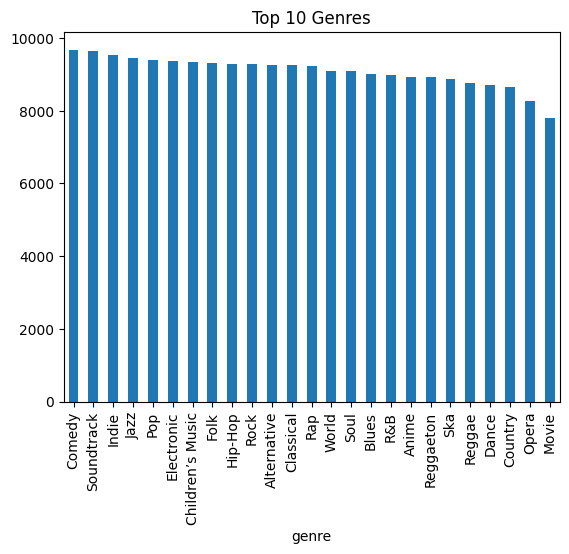

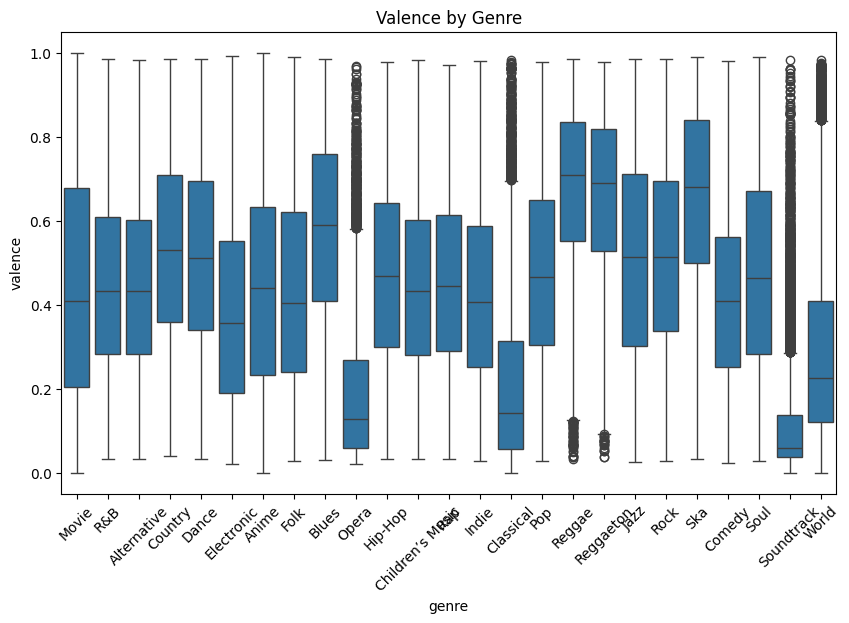

In [80]:
df['genre'].value_counts().head(25).plot(kind='bar')
plt.title('Top 10 Genres')
plt.show()

# Boxplots of valence by genre
top_genres = df['genre'].value_counts().head(25).index
subset = df[df['genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='genre', y='valence', data=subset)
plt.title('Valence by Genre')
plt.xticks(rotation=45)
plt.show()

The next step we decided to conduct was a formal outlier check using boxplots, to better visualize and confirm the analysis discussed earlier. Outlier detection is focused on the numeric features, as categorical outliers are not exactly outliers, just rare.

From the plots, we can observe:
- valence, energy, and danceability are normalized between 0 and 1, and contain minimal/no outliers
- tempo has some high end outliers, with BMP above 200, indicating there are some songs that are faster than the average song.
- acousticness does not have formal outliers, however it is heavily right skewed.
- duration contains extreme outliers, with some tracks lasting millions of seconds (over an hour). These may represent podcasts for example.

Most mood related features, such as valence, energy, and danceability are fairly consistent. Temp and acousticness show some variability, but this may be useful for finding distinct mood clusters. If kept, duration includes extreme values that may need to be dealt with if they are just noise before any model training.

Using IQR, we also counted the extreme outliers, and observed tempo has 168 extreme outliers, and duration 14651. Our plan for now is to keep tempo but scale it appropriately, and if used remove extreme values from duration.

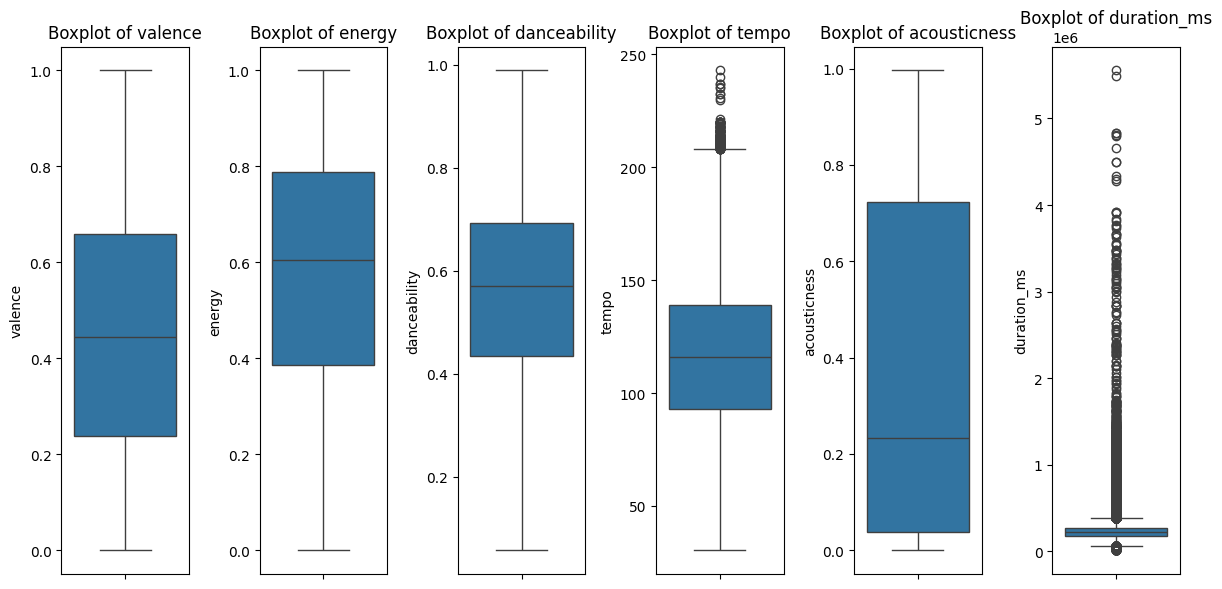

valence: 0 outliers
energy: 0 outliers
danceability: 0 outliers
tempo: 168 outliers
acousticness: 0 outliers
duration_ms: 14651 outliers


In [81]:
numeric_features = ['valence', 'energy', 'danceability', 'tempo', 'acousticness', 'duration_ms']

plt.figure(figsize=(12, 6))

# create boxplots for each feature
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: {len(outliers)} outliers")

Since we observed extreme outliers in duration, we hypothesized earlier that they may be podcasts. To better understand our outliers, we sorted the dataset by duration in descending order and examined the top entries.

Many tracks were around 70-90 minutes long, such as:
- Episode 15 and episode 14, which must be a podcast
- 6:00 AM, which seems to be a continuous mix of music
- Lost Lands 2017 mix, which seems to be a DJ mix
- Nature Sounds for Sleep, which is a sleep audio

These are clearly not standard songs, and they may bias the model as their unusually long durations do not reflect the average song. In the end, we will most probably exclude tracks longer than 15 minutes to reflect real world song lengths and maintain consistency so that real music is the main focus.

In [82]:
# Sort the DataFrame by duration in descending order
long_tracks = df.sort_values(by='duration_ms', ascending=False)

# Display the top 10 longest tracks
long_tracks[['track_name', 'artist_name', 'duration_ms', 'genre']]
long_tracks['duration_min'] = long_tracks['duration_ms'] / 60000
long_tracks[['track_name', 'artist_name', 'duration_min', 'genre']].head(5)

,track_name,artist_name,duration_min,genre
212083,"Episodio 15 (Lady Orinoco, Políticas De Youtub...",La Mesa Reñoña,92.548617,Comedy
162671,6 : 00 Am,DJ Luigi,91.466667,Reggaeton
23593,Lost Lands 2017 Mix,Excision,80.510100,Electronic
211969,"Episodio 14 (Machismo, Juanga, Bebé a Bordo)",La Mesa Reñoña,80.509733,Comedy
219057,Nature Sounds for Sleep: Crackling Log Fire wi...,Jamie Llewellyn,80.066917,World


Our initial exploratory data analysis focused on gaining a foundational understanding of the Spotify dataset before applying any mood labeling. Key findings include:

Dataset Structure:
The dataset contains 232725 tracks and 18 columns, most of which are numerical audio features suitable for machine learning.
- A few non-numerical columns (track_name, artist_name, track_id) were identified as irrelevant for modeling and will be excluded.

Feature Quality
- Missing values were nearly non-existent, with only 1 missing entry in track_name.
- All mood-related features are numerical and normalized or easily scaled.
- Data types for key, mode, and time_signature were noted for possible conversion.

Distribution and Correlation
- Distribution plots showed that core features look good, with slight skew in acousticness and tempo.
- A correlation heatmap confirmed strong internal structure:
  - Energy and loudness are highly correlated (as expected).
  - Valence, danceability, and energy show useful, but not redundant, overlap.

Outlier Detection using boxplots and IQR:
  - Valence, energy, danceability, and acousticness had no extreme outliers.
  - Tempo showed 168 fast-paced outliers, likely representing high-BPM music.
  - Duration_ms had over 14,000 extreme outliers, with durations often exceeding 1 hour.
- Manual inspection of top-duration tracks revealed non-music content (podcasts, ambient soundtracks, comedy specials).


In conclusion, the dataset is clean, and structured. Core features behave predictably and show interpretable relationships. We are now ready to proceed to K-Means clustering to generate mood labels.

# <font color='#3c3c3c'>EDA-2</font>

In [83]:
# Define separate feature sets
clustering_features = ['valence', 'energy', 'acousticness']
full_features = [
    'valence', 'energy', 'danceability', 'acousticness', 'tempo',
    'loudness', 'speechiness', 'instrumentalness', 'liveness'
]

# Step 1: Clustering feature matrix
X_cluster = df[clustering_features]

# Step 2: Full feature matrix for model training
X_full = df[full_features]


In [84]:
from sklearn.preprocessing import StandardScaler

# Scale clustering features
cluster_scaler = StandardScaler()
X_cluster_scaled = cluster_scaler.fit_transform(X_cluster)

# Scale full features
full_scaler = StandardScaler()
X_full_scaled = full_scaler.fit_transform(X_full)


In [85]:
from sklearn.cluster import KMeans
# Cluster using reduced feature set
kmeans = KMeans(n_clusters=5, random_state=42)
df['mood_cluster'] = kmeans.fit_predict(X_cluster_scaled[df.index, :])

# Optional: Drop unwanted cluster (e.g., Mellow, cluster 0)
df = df[df['mood_cluster'] != 0]

# Map mood_cluster to human-readable moods
cluster_to_mood = {
    1: 'Happy Party',
    2: 'Sad Acoustic',
    3: 'Chill Vibes',
    4: 'Energetic'
}
df['mood'] = df['mood_cluster'].map(cluster_to_mood)  # 👈 this must happen before using df['mood']

# Now build your model input using all features
X_model = pd.DataFrame(X_full_scaled[df.index], columns=full_features, index=df.index)
y_model = df['mood']


In [86]:
cluster_summary = df.groupby('mood_cluster')[features].mean()
print(cluster_summary)

                energy       tempo  acousticness  instrumentalness  \
mood_cluster                                                         
1             0.735867  122.459809      0.137532          0.060389   
2             0.520674  118.055950      0.234123          0.123729   
3             0.183793  105.508217      0.878255          0.397343   
4             0.491528  113.052411      0.707332          0.108158   

              danceability   loudness  speechiness  
mood_cluster                                        
1                 0.663868  -6.569255     0.098608  
2                 0.571693  -8.794751     0.114684  
3                 0.357272 -18.091559     0.065790  
4                 0.608492 -10.776423     0.253074  


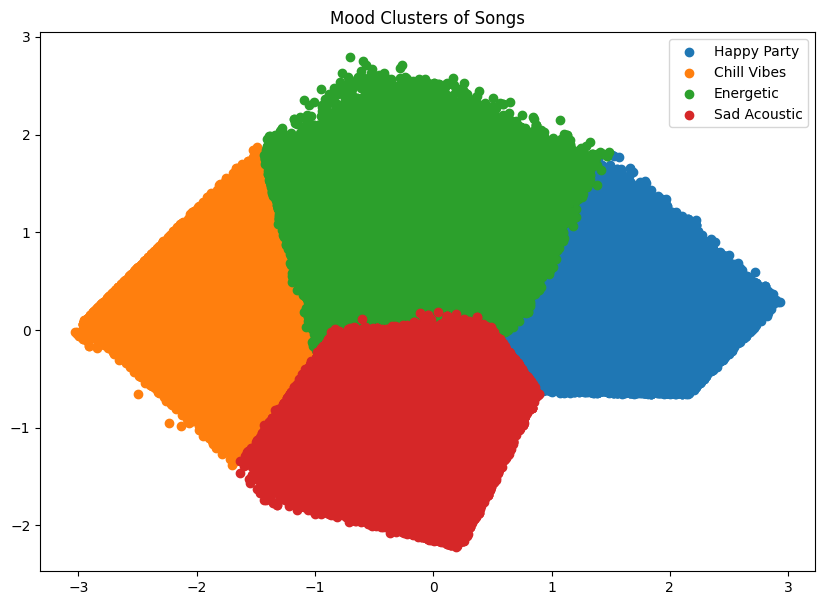

In [87]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# STEP 1: Filter X_scaled to match df after removing Mellow
X_filtered = X_cluster_scaled[df.index]  # keeps only rows still in df

# STEP 2: Run PCA on the filtered matrix
pca = PCA(n_components=2)
components = pca.fit_transform(X_filtered)

# STEP 3: Assign to df (now same shape)
df['pca1'] = components[:, 0]
df['pca2'] = components[:, 1]

# STEP 4: Plot
plt.figure(figsize=(10, 7))
for mood in df['mood'].dropna().unique():
    subset = df[df['mood'] == mood]
    plt.scatter(subset['pca1'], subset['pca2'], label=mood)

plt.legend()
plt.title("Mood Clusters of Songs")
plt.show()


In [88]:
cluster_summary = df.loc[df['mood_cluster'] != 0].groupby('mood_cluster')[[
    'valence', 'energy', 'danceability', 'acousticness',
    'tempo', 'loudness', 'speechiness', 'instrumentalness', 'liveness'
]].mean().round(2)

print(cluster_summary)


              valence  energy  danceability  acousticness   tempo  loudness  \
mood_cluster                                                                  
1                0.76    0.74          0.66          0.14  122.46     -6.57   
2                0.27    0.52          0.57          0.23  118.06     -8.79   
3                0.17    0.18          0.36          0.88  105.51    -18.09   
4                0.60    0.49          0.61          0.71  113.05    -10.78   

              speechiness  instrumentalness  liveness  
mood_cluster                                           
1                    0.10              0.06      0.20  
2                    0.11              0.12      0.19  
3                    0.07              0.40      0.17  
4                    0.25              0.11      0.30  


Valence X Energy
The scatterplot below shows the interaction between valence and energy by mood. We chose to analyze valence and energy since they are similar ideas conceptually and we wanted to see how related to each other they are and how related they are in turn to mood. From this plot, we can see that there features are not fully seperable but do have distict regions. Happy party (green) dominates the upper right which makes sense as this means its both very energetic and very positive. Sad acoustic (purple) remains mostly in the lower left, impliying that these have lower valence and energy. Chill vibes (orange) is in the lower region of energ but does vary more as far as valence. Mellow (red) is sparsed and very mixed in the graph which means that it could be underrepresented or hard to distinguish, while Energetic (blue) overlaps with happy party but spreads slightly towards mid-valence. From this information we can conclude that we are going to need more nuanced features in order to distinguish the moods. 


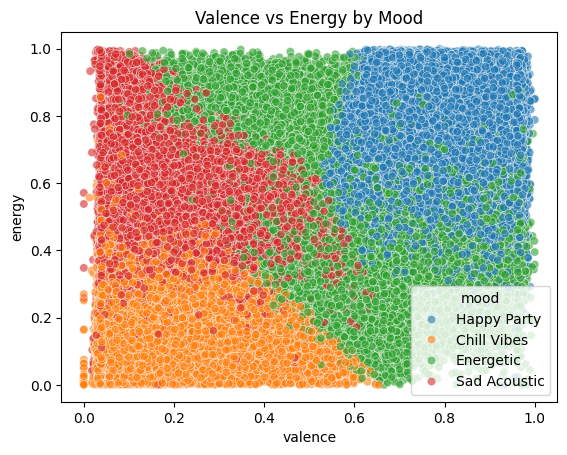

In [89]:
sns.scatterplot(data=df, x='valence', y='energy', hue='mood', alpha=0.6)
plt.title('Valence vs Energy by Mood')
plt.show()


Valency by Mood
The KDE plot below shows the distribution of valency by mood. The x axis shows the range of valency from 0 (sad/angry/negative) to 1 (happy/joyful), while the y axis shows the relative number of songs per mood. From this plot we can see that Chill Vibes (orange) has an extremely low valence, Happy Party (green) has pretty strong right skew towards valence (0.7- 1.0), Sad Acoustic (purple) is more spread out in lower valence, peaking just above 0.2. Mellow (red) is a flatter distribution from 0.1 to 0.6 which means that it might be tougher to distinguish, meaning that valence alone is not the best feature to understand the mellow category.  Finally, Energetic (blue), peaks around 0.4 and 0.6 and does also overlap with several classes. What this shows us is that valency is very good at seperating between chill vibes and happy party but may be limited as far as the other moods are concerned.  

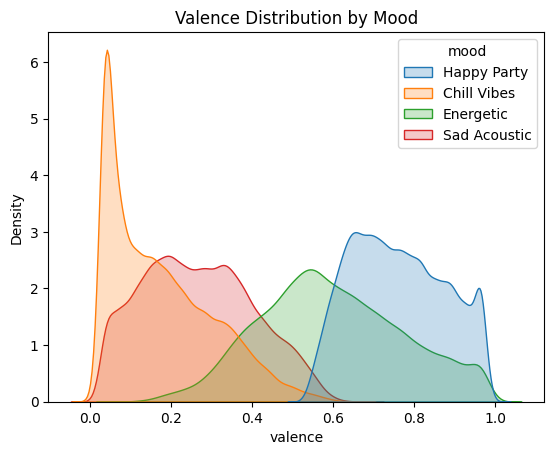

In [90]:
sns.kdeplot(data=df, x='valence', hue='mood', common_norm=False, fill=True)
plt.title("Valence Distribution by Mood")
plt.show()


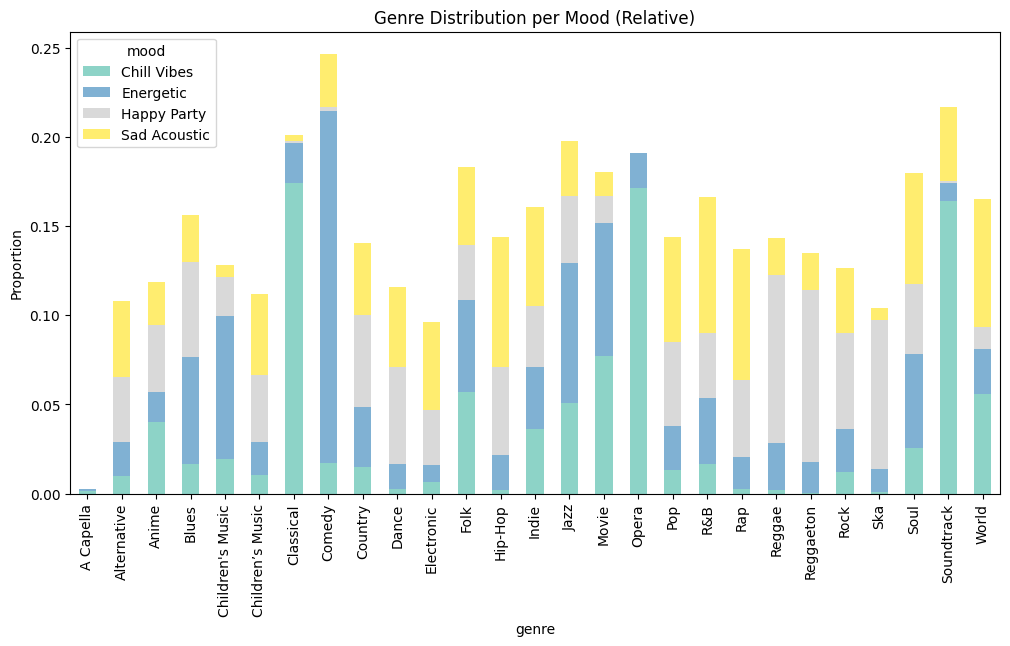

In [91]:
genre_mood_ct = pd.crosstab(df['mood'], df['genre'])
genre_mood_ct = genre_mood_ct.div(genre_mood_ct.sum(axis=1), axis=0)

genre_mood_ct.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title("Genre Distribution per Mood (Relative)")
plt.ylabel("Proportion")
plt.show()


/var/folders/k_/6rdzd8bs0m52481_1n51s7n80000gn/T/ipykernel_34928/3810839516.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')


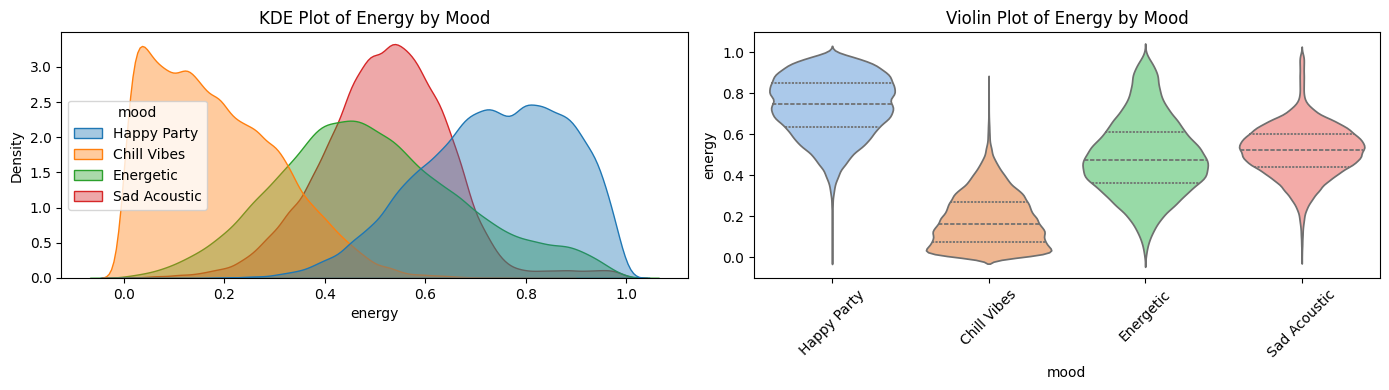

/var/folders/k_/6rdzd8bs0m52481_1n51s7n80000gn/T/ipykernel_34928/3810839516.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')


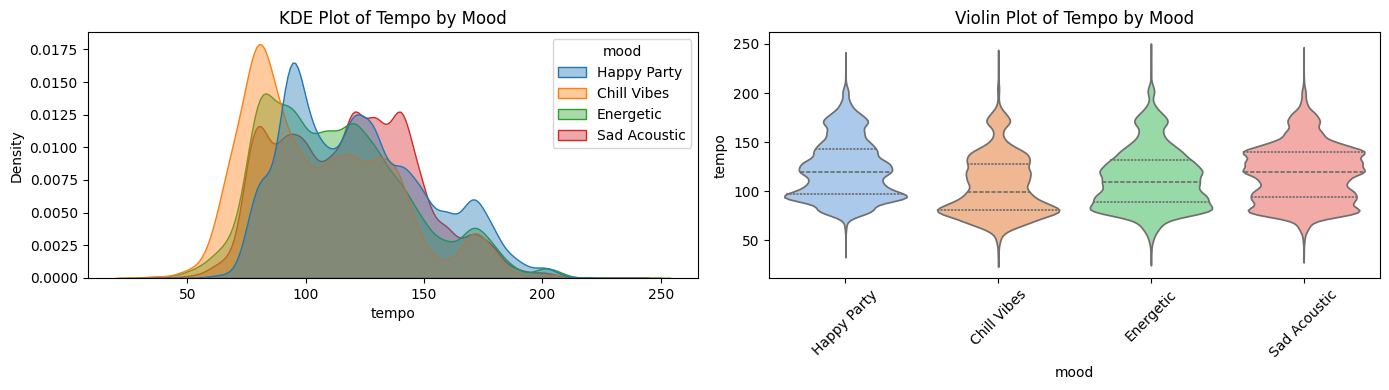

/var/folders/k_/6rdzd8bs0m52481_1n51s7n80000gn/T/ipykernel_34928/3810839516.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')


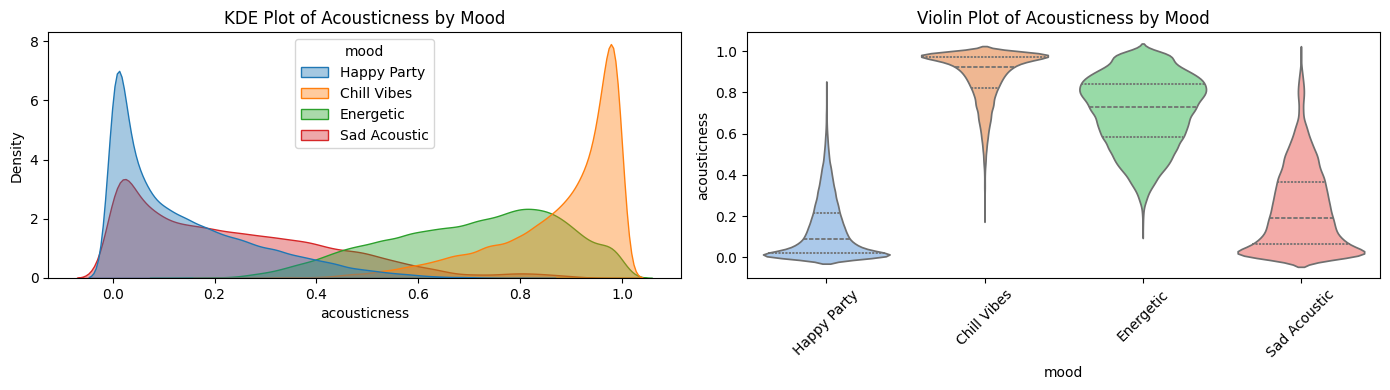

/var/folders/k_/6rdzd8bs0m52481_1n51s7n80000gn/T/ipykernel_34928/3810839516.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')


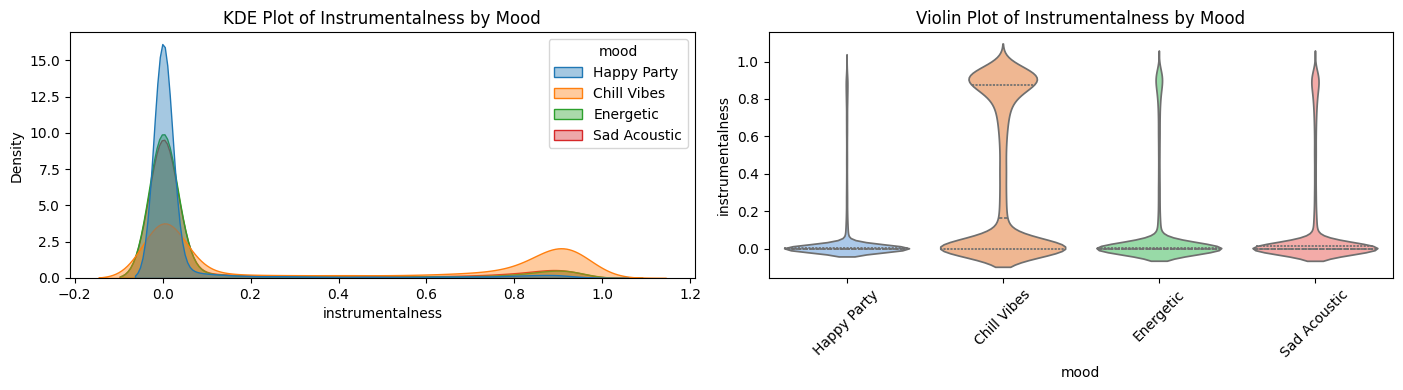

/var/folders/k_/6rdzd8bs0m52481_1n51s7n80000gn/T/ipykernel_34928/3810839516.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')


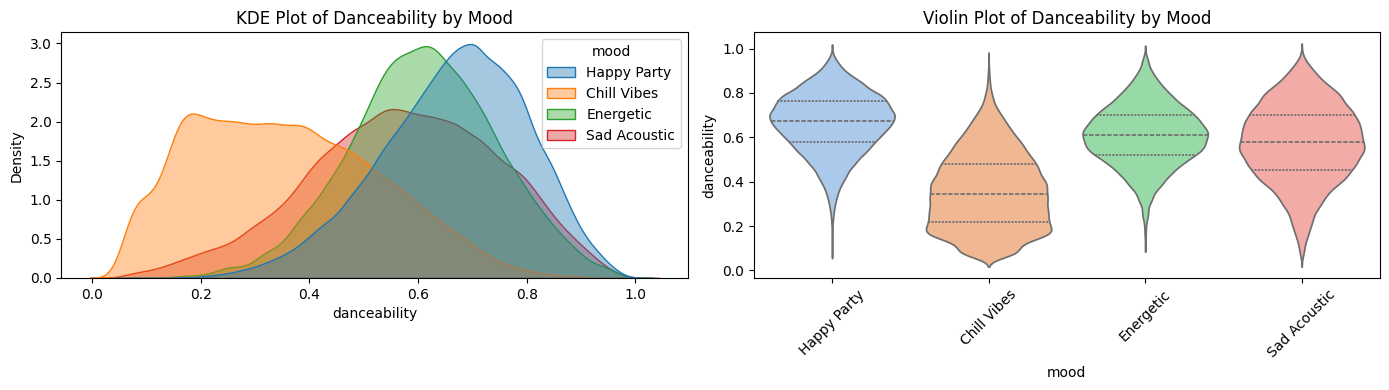

/var/folders/k_/6rdzd8bs0m52481_1n51s7n80000gn/T/ipykernel_34928/3810839516.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')


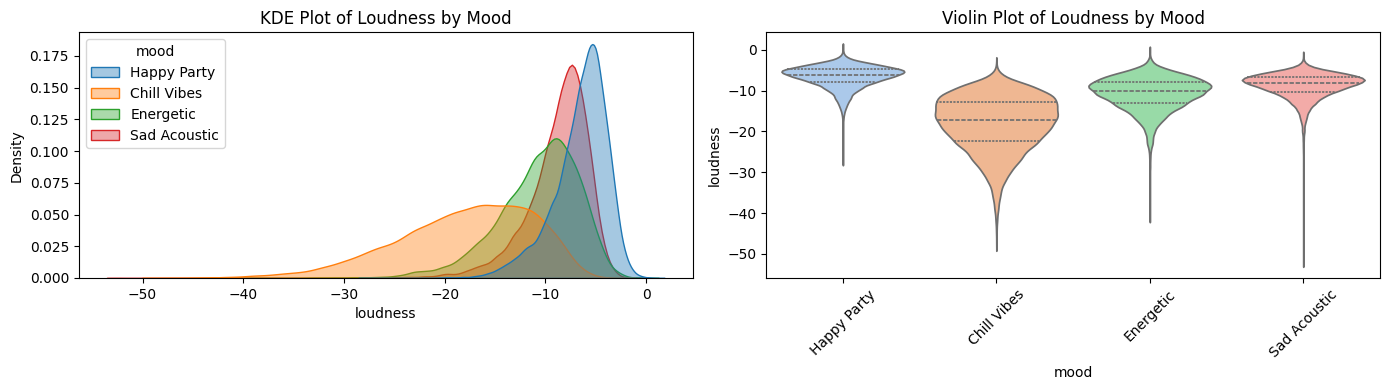

/var/folders/k_/6rdzd8bs0m52481_1n51s7n80000gn/T/ipykernel_34928/3810839516.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')


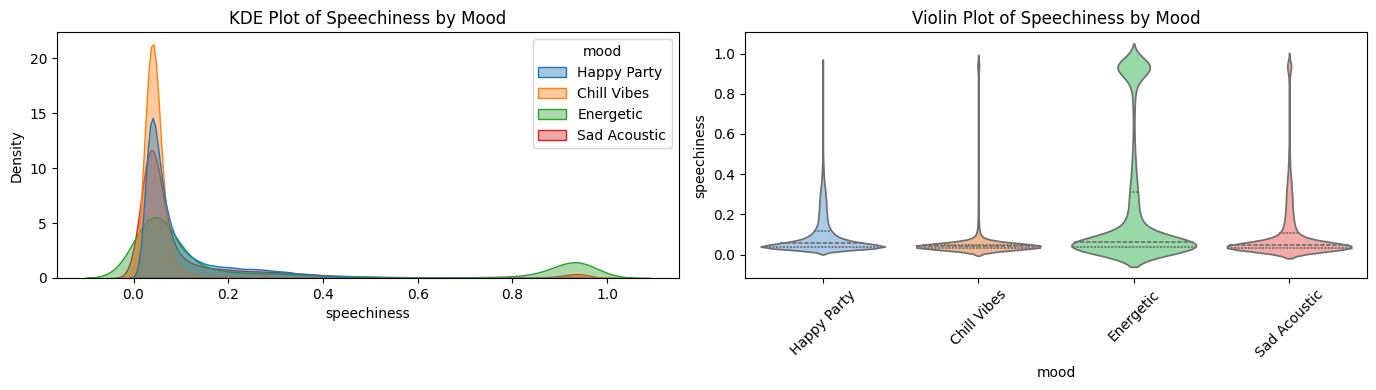

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features you want to explore
features = ['energy', 'tempo', 'acousticness', 'instrumentalness', 
            'danceability', 'loudness', 'speechiness']

# Loop through each feature
for feature in features:
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    # KDE Plot
    sns.kdeplot(data=df, x=feature, hue='mood', fill=True, common_norm=False, alpha=0.4, ax=axs[0])
    axs[0].set_title(f"KDE Plot of {feature.capitalize()} by Mood")

    # Violin Plot
    sns.violinplot(data=df, x='mood', y=feature, ax=axs[1], inner='quartile', palette='pastel')
    axs[1].set_title(f"Violin Plot of {feature.capitalize()} by Mood")
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


# <font color='#3c3c3c'>Handling Missing values</font>

One row in the dataset contained a missing value (track name) and was dropped during preprocessing. Given the dataset’s large size, this removal will have no impact on the analysis or model performance

In [93]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,loudness,mode,speechiness,tempo,time_signature,valence,mood_cluster,mood,pca1,pca2
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,...,-1.828,Major,0.0525,166.969,4/4,0.814,1,Happy Party,1.442512,1.003296
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,...,-5.559,Minor,0.0868,174.003,4/4,0.816,1,Happy Party,1.633615,0.466416
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,...,-13.879,Minor,0.0362,99.488,5/4,0.368,3,Chill Vibes,-1.824364,0.875608
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,...,-12.178,Major,0.0395,171.758,4/4,0.227,3,Chill Vibes,-1.347059,-0.112419
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,...,-21.150,Major,0.0456,140.576,4/4,0.390,3,Chill Vibes,-1.565170,0.870753


In [94]:
df.dropna(inplace=True)

# <font color='#3c3c3c'>Data Splitting</font>

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
# define target and features
y = df["mood"]
X = df.drop(columns=["mood"])

# first split (80% training, 20% others)
X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# second split (10% validation, 10% test)
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other, test_size=0.5, stratify=y_other, random_state=42
)

# check
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)


Training Set: (110280, 21) (110280,)
Validation Set: (36760, 21) (36760,)
Test Set: (36761, 21) (36761,)


# <font color='#3c3c3c'>Data Imputation</font>

# <font color='#3c3c3c'>Creating New Features</font>

In [97]:
# List of columns to drop
drop_cols = [
    'track_name',      
    'track_id',        
    'artist_name',     
    'genre',            
    'duration_ms',
    'popularity',
    'pca1', 'pca2',
    'umap1', 'umap2',
    'mood_cluster'
]

# Drop from X_train and X_test
X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns])
X_test = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

print("Dropped unnecessary and leaky columns.")

# Now create new features on X_train and X_test
X_train['loud_energy'] = X_train['energy'] * X_train['loudness']
X_test['loud_energy'] = X_test['energy'] * X_test['loudness']

X_train['dance_tempo'] = X_train['danceability'] * X_train['tempo']
X_test['dance_tempo'] = X_test['danceability'] * X_test['tempo']

X_train['feel_good'] = X_train['valence'] * X_train['danceability']
X_test['feel_good'] = X_test['valence'] * X_test['danceability']

print("Created new interaction features.")

Dropped unnecessary and leaky columns.
Created new interaction features.


# <font color='#3c3c3c'>Encoding Categorical Variables</font>

In [98]:
X_train.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,loud_energy,dance_tempo,feel_good
207108,0.8480,0.217,0.1080,0.244000,A,0.3340,-18.620,Major,0.0345,76.792,4/4,0.0428,-2.010960,16.663864,0.009288
208840,0.9550,0.300,0.0972,0.000000,C,0.0894,-15.390,Major,0.0399,81.543,3/4,0.1630,-1.495908,24.462900,0.048900
217846,0.3530,0.332,0.4340,0.000055,G#,0.0932,-8.081,Major,0.0304,139.637,4/4,0.1800,-3.507154,46.359484,0.059760
152636,0.4290,0.653,0.4140,0.000051,G#,0.1140,-9.079,Minor,0.2430,143.828,4/4,0.2610,-3.758706,93.919684,0.170433
119818,0.0762,0.888,0.6440,0.000000,C,0.0646,-8.320,Major,0.1550,100.021,4/4,0.3200,-5.358080,88.818648,0.284160


In [99]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# === 1. Label encode 'mode' ===
le = LabelEncoder()

X_train['mode'] = le.fit_transform(X_train['mode'])
X_val['mode'] = le.transform(X_val['mode'])
X_test['mode'] = le.transform(X_test['mode'])

# === 2. One-hot encode 'key' and 'time_signature' ===
X_train = pd.get_dummies(X_train, columns=['key', 'time_signature'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['key', 'time_signature'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['key', 'time_signature'], drop_first=True)

# === 3. Align datasets ===
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [100]:
print(X_train.columns)

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence',
       'loud_energy', 'dance_tempo', 'feel_good', 'key_A#', 'key_B', 'key_C',
       'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G',
       'key_G#', 'time_signature_1/4', 'time_signature_3/4',
       'time_signature_4/4', 'time_signature_5/4'],
      dtype='object')


# <font color='#3c3c3c'>Feature Scaling</font>

In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Then transform val and test with the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

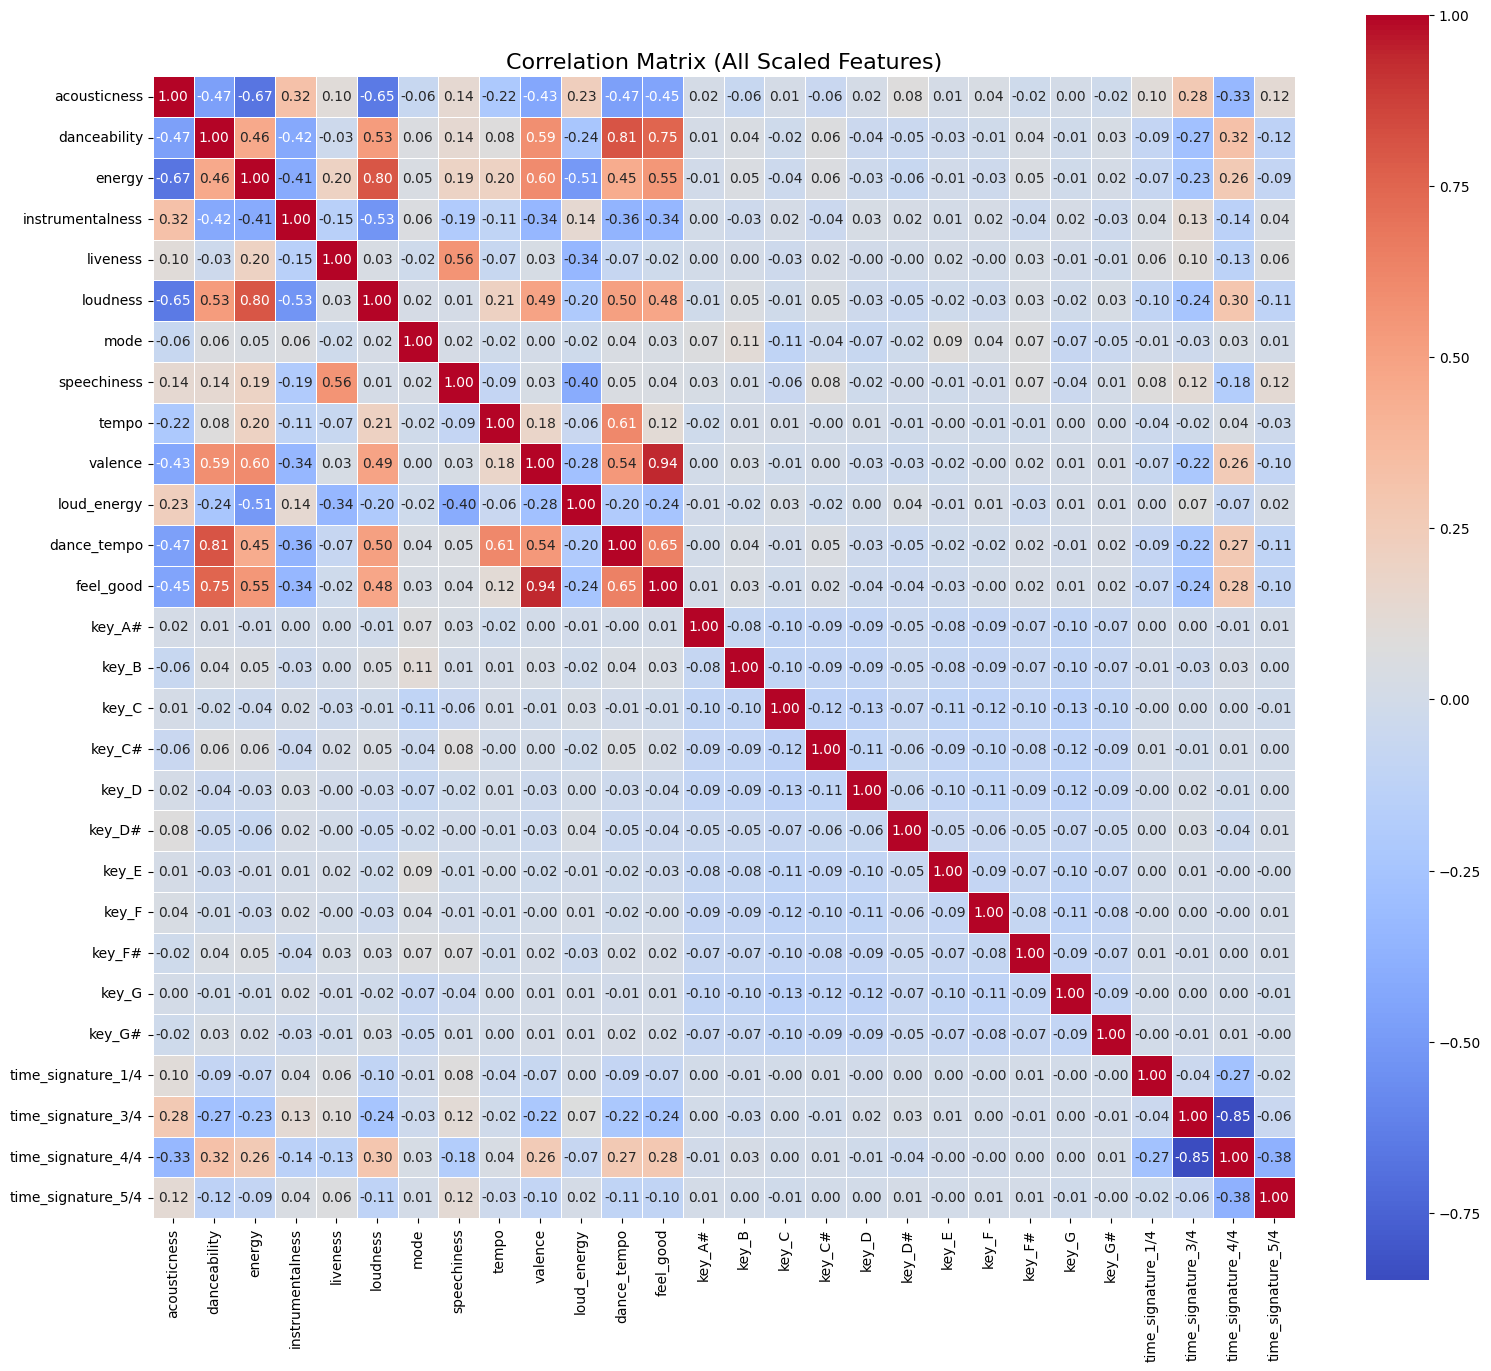

In [102]:
column_names = X_train.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)

corr_matrix = X_train_scaled_df.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix (All Scaled Features)", fontsize=16)
plt.tight_layout()
plt.show()

# <font color='#3c3c3c'>Adressing Class Imbalance</font>

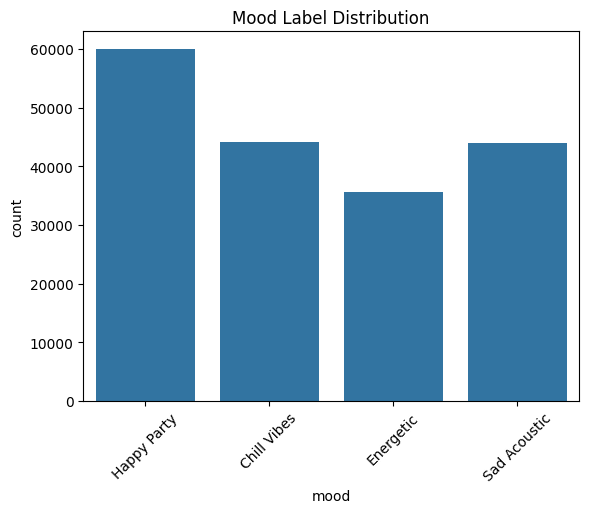

mood
Happy Party     0.326358
Chill Vibes     0.240477
Sad Acoustic    0.239193
Energetic       0.193971
Name: proportion, dtype: float64


In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot
sns.countplot(x=df['mood'])
plt.title("Mood Label Distribution")
plt.xticks(rotation=45)
plt.show()

# Or print counts
print(df['mood'].value_counts(normalize=True))

In [104]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced')

In [105]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [106]:
import pandas as pd

print("After Resampling (SMOTE):")
print(pd.Series(y_train_resampled).value_counts())
print(pd.Series(y_train_resampled).value_counts(normalize=True))

After Resampling (SMOTE):
mood
Chill Vibes     35991
Sad Acoustic    35991
Happy Party     35991
Energetic       35991
Name: count, dtype: int64
mood
Chill Vibes     0.25
Sad Acoustic    0.25
Happy Party     0.25
Energetic       0.25
Name: proportion, dtype: float64


# <font color='#3c3c3c'>Feature Selection</font>

In [107]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold (example: 0.01)
selector = VarianceThreshold(threshold=0.01)

# Fit on scaled train set
selector.fit(X_train_resampled)

# Get mask of kept features
high_variance_mask = selector.get_support()

# Apply mask to get selected features
X_train_high_variance = X_train_resampled[:, high_variance_mask]
X_val_high_variance = X_val_scaled[:, high_variance_mask]
X_test_high_variance = X_test_scaled[:, high_variance_mask]

# Get column names of kept features
selected_features = X_train.columns[high_variance_mask]
print("Selected features after Variance Threshold:\n", selected_features.tolist())

Selected features after Variance Threshold:
 ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'loud_energy', 'dance_tempo', 'feel_good', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'time_signature_1/4', 'time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4']


In [108]:
import numpy as np
import pandas as pd

# If you still have the column names from before:
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# Now this will work
corr_matrix = X_train_resampled_df.corr().abs()

# Step 2: Get upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3A: Print highly correlated pairs
threshold = 0.7
high_corr_pairs = [(col1, col2, upper.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.index
                   if upper.loc[col1, col2] > threshold]

print("Highly correlated feature pairs (>|0.7|):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} and {col2}: {corr_val:.2f}")

Highly correlated feature pairs (>|0.7|):
danceability and dance_tempo: 0.81
danceability and feel_good: 0.75
energy and loudness: 0.79
valence and feel_good: 0.94
time_signature_3/4 and time_signature_4/4: 0.85


In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to compute VIF
X_temp = X_train_resampled_df.copy()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_temp.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

               Feature          VIF
26  time_signature_4/4  6723.074637
25  time_signature_3/4  5327.003773
27  time_signature_5/4  1276.915618
24  time_signature_1/4   680.815930
11         dance_tempo    24.707596
12           feel_good    21.252643
1         danceability    17.803081
9              valence    15.280540
8                tempo     8.681357
2               energy     6.239389
5             loudness     4.531368
0         acousticness     2.374099
7          speechiness     2.210999
15               key_C     2.013557
10         loud_energy     1.968293
22               key_G     1.950406
17               key_D     1.862361
16              key_C#     1.821525
4             liveness     1.777447
20               key_F     1.774201
19               key_E     1.648612
14               key_B     1.613802
13              key_A#     1.603155
3     instrumentalness     1.593441
23              key_G#     1.567154
21              key_F#     1.559270
18              key_D#     1

In [110]:
to_drop = ['energy', 'dance_tempo', 'feel_good', 'time_signature_4/4']

X_train_reduced = X_train_resampled_df.drop(columns=to_drop)
X_val_reduced = pd.DataFrame(X_val_scaled, columns=X_train_resampled_df.columns).drop(columns=to_drop)
X_test_reduced = pd.DataFrame(X_test_scaled, columns=X_train_resampled_df.columns).drop(columns=to_drop)

print(X_train_reduced.head())


   acousticness  danceability  instrumentalness  liveness  loudness      mode  \
0      1.125708     -1.758866          0.245768  0.619711 -1.281076 -0.721265   
1      1.427986     -1.330455         -0.518026 -0.604745 -0.759722 -0.721265   
2     -0.272685     -1.165284         -0.517855 -0.585722  0.420024 -0.721265   
3     -0.057982      0.491584         -0.517865 -0.481599  0.258937  1.386454   
4     -1.054655      1.704556         -0.518026 -0.728893  0.381447 -0.721265   

   speechiness     tempo   valence  loud_energy  ...     key_D    key_D#  \
0    -0.450651 -1.258223 -1.508301     1.174485  ... -0.338465 -0.189887   
1    -0.423670 -1.103886 -1.083206     1.458691  ... -0.338465 -0.189887   
2    -0.471136  0.783310 -1.023084     0.348883  ... -0.338465 -0.189887   
3     0.591103  0.919455 -0.736622     0.210076  ... -0.338465 -0.189887   
4     0.151418 -0.503624 -0.527964    -0.672460  ... -0.338465 -0.189887   

     key_E     key_F    key_F#     key_G    key_G#  time

# <font color='#3c3c3c'>Baseline</font>

Validation Accuracy: 0.7360

Classification Report:
              precision    recall  f1-score   support

 Chill Vibes       0.69      1.00      0.81      8840
   Energetic       0.56      0.67      0.61      7130
 Happy Party       1.00      0.54      0.70     11997
Sad Acoustic       0.78      0.80      0.79      8793

    accuracy                           0.74     36760
   macro avg       0.76      0.75      0.73     36760
weighted avg       0.79      0.74      0.73     36760



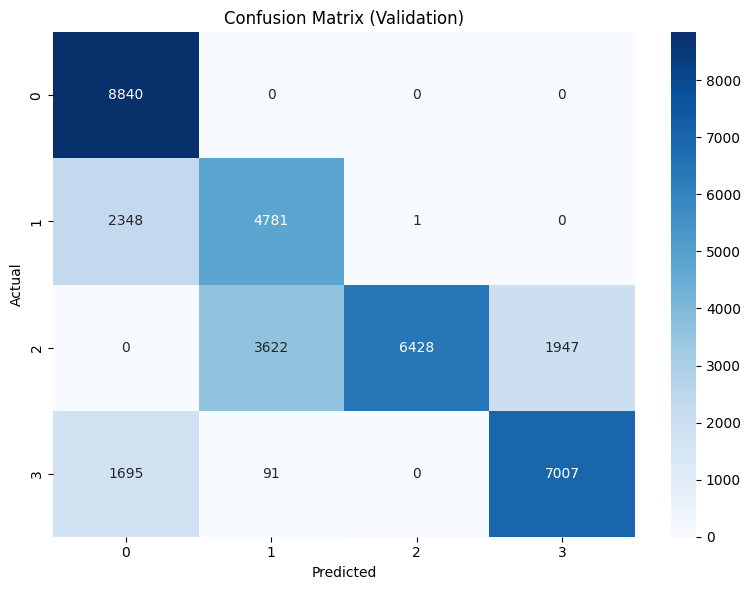

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_reduced, y_train_resampled)

# Predict on validation set
y_val_pred = lr.predict(X_val_reduced)

# === Evaluation ===
# Accuracy
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Gradient Boost

Validation Accuracy (Gradient Boosting): 0.8760

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

 Chill Vibes       0.74      1.00      0.85      8840
   Energetic       0.81      0.73      0.77      7130
 Happy Party       0.99      0.89      0.94     11997
Sad Acoustic       0.97      0.86      0.91      8793

    accuracy                           0.88     36760
   macro avg       0.88      0.87      0.87     36760
weighted avg       0.89      0.88      0.88     36760



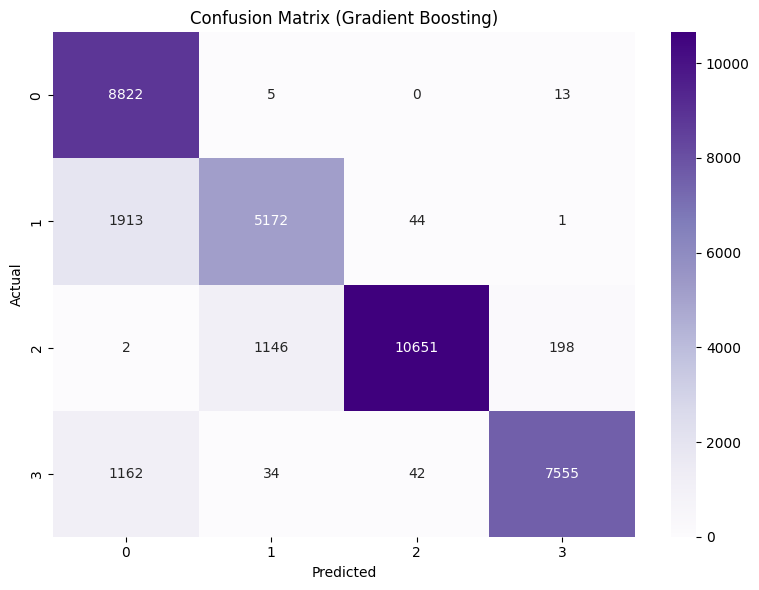

In [119]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Train Gradient Boosting ===
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_reduced, y_train_resampled)

# === Predict ===
y_val_pred = gb.predict(X_val_reduced)

# === Evaluation ===
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Gradient Boosting): {val_acc:.4f}")

print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_val, y_val_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix (Gradient Boosting)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Random Forrest

Validation Accuracy (Random Forest): 0.8891

Classification Report (Random Forest):
              precision    recall  f1-score   support

 Chill Vibes       0.75      1.00      0.86      8840
   Energetic       0.85      0.73      0.79      7130
 Happy Party       0.99      0.91      0.95     11997
Sad Acoustic       0.98      0.87      0.92      8793

    accuracy                           0.89     36760
   macro avg       0.89      0.88      0.88     36760
weighted avg       0.90      0.89      0.89     36760



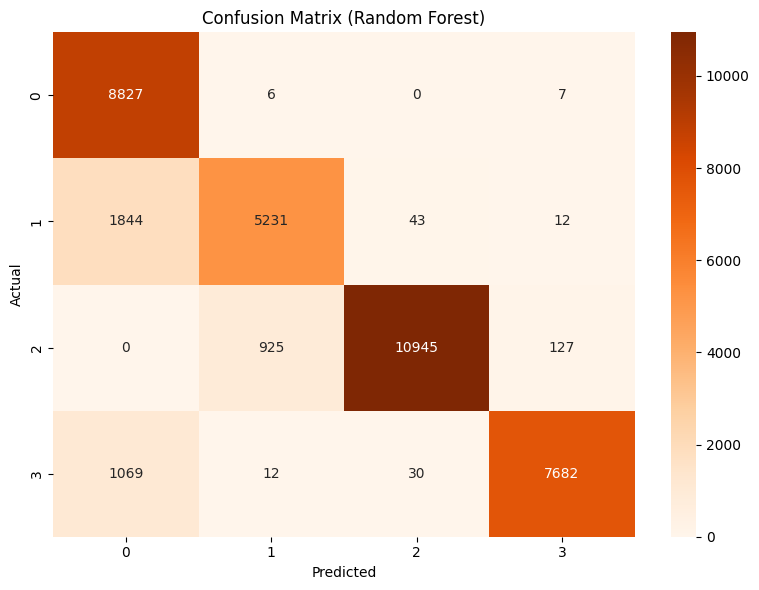

In [120]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_reduced, y_train_resampled)

# Predict
y_val_pred = rf.predict(X_val_reduced)

# Evaluate
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Random Forest): {val_acc:.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
